In [1]:
import os
import pickle
import numpy as np
np.random.seed(42)
import pandas as pd
import keras
from keras.models import Model
from keras.layers import Embedding, Dense, Dropout, Input, Concatenate, Flatten
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.model_selection import train_test_split as splt
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

Using TensorFlow backend.


In [2]:
dfy = pd.read_csv("MILANO_wSCORE.csv")
dfx = pd.read_csv("PLIC-milano-processed.csv", sep=";")

/home/webvalley/anaconda3/envs/score/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (14,29,36,44,51,94,104,105,112,113,120,127,130,149,158,168,237,239,240,241,248,249,256,273,298) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Thresholds are 0 - 0.01, 0.01 - 0.02, 0.02 - 0.05, 0.05 - 1
y = dfy["SCORE"].values/100
y_cat = np.zeros((y.shape[0], 4))
for i, val in enumerate(y):
    if(val < 0.01):
        y_cat[i][0] = 1
    elif(val < 0.02):
        y_cat[i][1] = 1
    elif(val < 0.05):
        y_cat[i][2] = 1
    else:
        y_cat[i][3] = 1

In [4]:
dfx = dfx.select_dtypes(exclude=['object'])
dfx = dfx.drop(labels = ['Unnamed: 0', 'Unnamed: 0.1', 'cod pcs'], axis=1) 
dfx = dfx.dropna(how='any', axis=1)
dfx = dfx.drop([col for col in dfx.columns if "date" in col], axis = 1)

In [5]:
def joi(df, df2, sta):
    for st in sta:
        df2 = df2.join(df[st])
    return df2

dfxFloats = dfx.select_dtypes(include = 'float')
dfxInt = dfx.select_dtypes(include = 'int')
dfxFloats = joi(dfx, dfxFloats, [a for a in dfxInt.columns if (dfxInt[a].max()) > 1])
dfxInt = dfxInt.drop([a for a in dfxInt.columns if (dfxInt[a].max()) > 1], axis = 1)
dfxInt = dfxInt[dfxInt.columns[dfxInt.max()>0]]

In [6]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
#print_full(dfxInt.max())
#print_full(dfxFloats.max())

In [7]:
xCat = dfxInt.values
xCont = dfxFloats.values

In [8]:
print(xCat.shape)
print(xCont.shape)

(5780, 79)
(5780, 93)


In [9]:
contIn = Input(shape=(xCont.shape[1],))
catIn = Input(shape=(xCat.shape[1],))
#catBranch = Embedding(3000, 100)(catIn)
#catBranch = Flatten()(catBranch)

contBranch = Dense(32, activation='sigmoid')(contIn)
contBranch = Dropout(0.2)(contBranch)
contBranch = Dense(16, activation='sigmoid')(contBranch)
contBranch = Dropout(0.2)(contBranch)

catBranch = Dense(32, activation='sigmoid')(catIn)
catBranch = Dropout(0.2)(catBranch)
catBranch = Dense(16, activation='sigmoid')(catBranch)
catBranch = Dropout(0.2)(catBranch)


model = Concatenate()([contBranch, catBranch])
output = Dense(4, activation='softmax')(model)

model = Model(inputs = [contIn, catIn], outputs = [output])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
x_Cat_tr, x_Cat_ts, x_Cont_tr, x_Cont_ts, y_tr, y_ts = splt(xCat, xCont, y_cat, test_size=0.25, random_state=42)

In [11]:
es = EarlyStopping(patience = 100, restore_best_weights = True)
history = model.fit(x=[x_Cont_tr, x_Cat_tr], y=y_tr, validation_data=([x_Cont_ts, x_Cat_ts], y_ts), epochs=500, callbacks = [es])

Instructions for updating:
Use tf.cast instead.
Train on 4335 samples, validate on 1445 samples
Epoch 1/500
4335/4335 [==============================] - 0s 94us/step - loss: 1.3921 - acc: 0.3211 - val_loss: 1.3216 - val_acc: 0.3875
Epoch 2/500
4335/4335 [==============================] - 0s 29us/step - loss: 1.3322 - acc: 0.3550 - val_loss: 1.2913 - val_acc: 0.3965
Epoch 3/500
4335/4335 [==============================] - 0s 29us/step - loss: 1.2942 - acc: 0.4000 - val_loss: 1.2498 - val_acc: 0.4478
Epoch 4/500
4335/4335 [==============================] - 0s 29us/step - loss: 1.2459 - acc: 0.4369 - val_loss: 1.2019 - val_acc: 0.4734
Epoch 5/500
4335/4335 [==============================] - 0s 29us/step - loss: 1.2029 - acc: 0.4586 - val_loss: 1.1599 - val_acc: 0.4810
Epoch 6/500
4335/4335 [==============================] - 0s 28us/step - loss: 1.1605 - acc: 0.4835 - val_loss: 1.1196 - val_acc: 0.5031
Epoch 7/500
4335/4335 [==============================] - 0s 28us/step - loss: 1.1307 - a

4335/4335 [==============================] - 0s 28us/step - loss: 0.7299 - acc: 0.6736 - val_loss: 0.7075 - val_acc: 0.6920
Epoch 59/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.7230 - acc: 0.6851 - val_loss: 0.7726 - val_acc: 0.6367
Epoch 60/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.7419 - acc: 0.6699 - val_loss: 0.7053 - val_acc: 0.6920
Epoch 61/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.7321 - acc: 0.6803 - val_loss: 0.7354 - val_acc: 0.6699
Epoch 62/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.7287 - acc: 0.6761 - val_loss: 0.7065 - val_acc: 0.6810
Epoch 63/500
4335/4335 [==============================] - 0s 28us/step - loss: 0.7382 - acc: 0.6736 - val_loss: 0.7018 - val_acc: 0.7003
Epoch 64/500
4335/4335 [==============================] - 0s 28us/step - loss: 0.7291 - acc: 0.6828 - val_loss: 0.7065 - val_acc: 0.6900
Epoch 65/500
4335/4335 [==============================

Epoch 118/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.6132 - acc: 0.7419 - val_loss: 0.5886 - val_acc: 0.7585
Epoch 119/500
4335/4335 [==============================] - 0s 28us/step - loss: 0.6159 - acc: 0.7403 - val_loss: 0.6117 - val_acc: 0.7377
Epoch 120/500
4335/4335 [==============================] - 0s 28us/step - loss: 0.6254 - acc: 0.7322 - val_loss: 0.6231 - val_acc: 0.7294
Epoch 121/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.6215 - acc: 0.7273 - val_loss: 0.6055 - val_acc: 0.7467
Epoch 122/500
4335/4335 [==============================] - 0s 28us/step - loss: 0.6300 - acc: 0.7264 - val_loss: 0.6425 - val_acc: 0.7170
Epoch 123/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.6163 - acc: 0.7306 - val_loss: 0.5997 - val_acc: 0.7363
Epoch 124/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.6198 - acc: 0.7345 - val_loss: 0.6052 - val_acc: 0.7308
Epoch 125/500
4335/4335 [=========

4335/4335 [==============================] - 0s 26us/step - loss: 0.5652 - acc: 0.7603 - val_loss: 0.5569 - val_acc: 0.7647
Epoch 178/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5802 - acc: 0.7548 - val_loss: 0.5597 - val_acc: 0.7675
Epoch 179/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5725 - acc: 0.7546 - val_loss: 0.5369 - val_acc: 0.7758
Epoch 180/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5594 - acc: 0.7670 - val_loss: 0.5656 - val_acc: 0.7557
Epoch 181/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5770 - acc: 0.7511 - val_loss: 0.5495 - val_acc: 0.7661
Epoch 182/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5762 - acc: 0.7463 - val_loss: 0.5571 - val_acc: 0.7640
Epoch 183/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5543 - acc: 0.7682 - val_loss: 0.6364 - val_acc: 0.7121
Epoch 184/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 26us/step - loss: 0.5397 - acc: 0.7730 - val_loss: 0.5558 - val_acc: 0.7585
Epoch 237/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5372 - acc: 0.7719 - val_loss: 0.5451 - val_acc: 0.7599
Epoch 238/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5492 - acc: 0.7712 - val_loss: 0.5667 - val_acc: 0.7509
Epoch 239/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5469 - acc: 0.7668 - val_loss: 0.5554 - val_acc: 0.7619
Epoch 240/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5707 - acc: 0.7587 - val_loss: 0.5424 - val_acc: 0.7799
Epoch 241/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5553 - acc: 0.7649 - val_loss: 0.5378 - val_acc: 0.7765
Epoch 242/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5243 - acc: 0.7774 - val_loss: 0.5441 - val_acc: 0.7716
Epoch 243/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 28us/step - loss: 0.5090 - acc: 0.7841 - val_loss: 0.5539 - val_acc: 0.7606
Epoch 296/500
4335/4335 [==============================] - 0s 28us/step - loss: 0.5185 - acc: 0.7769 - val_loss: 0.5180 - val_acc: 0.7841
Epoch 297/500
4335/4335 [==============================] - 0s 28us/step - loss: 0.5123 - acc: 0.7813 - val_loss: 0.5308 - val_acc: 0.7716
Epoch 298/500
4335/4335 [==============================] - 0s 28us/step - loss: 0.5035 - acc: 0.7896 - val_loss: 0.5744 - val_acc: 0.7460
Epoch 299/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.5152 - acc: 0.7795 - val_loss: 0.5398 - val_acc: 0.7737
Epoch 300/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.5390 - acc: 0.7732 - val_loss: 0.5562 - val_acc: 0.7550
Epoch 301/500
4335/4335 [==============================] - 0s 28us/step - loss: 0.5199 - acc: 0.7758 - val_loss: 0.5166 - val_acc: 0.7792
Epoch 302/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 28us/step - loss: 0.4916 - acc: 0.7942 - val_loss: 0.5995 - val_acc: 0.7446
Epoch 355/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.5044 - acc: 0.7806 - val_loss: 0.5602 - val_acc: 0.7571
Epoch 356/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.4891 - acc: 0.7896 - val_loss: 0.5358 - val_acc: 0.7772
Epoch 357/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.4901 - acc: 0.7903 - val_loss: 0.5193 - val_acc: 0.7952
Epoch 358/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.5094 - acc: 0.7746 - val_loss: 0.5818 - val_acc: 0.7474
Epoch 359/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.4874 - acc: 0.7910 - val_loss: 0.5682 - val_acc: 0.7550
Epoch 360/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.5130 - acc: 0.7783 - val_loss: 0.6076 - val_acc: 0.7322
Epoch 361/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 28us/step - loss: 0.4817 - acc: 0.7982 - val_loss: 0.5695 - val_acc: 0.7557
Epoch 414/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.4713 - acc: 0.7956 - val_loss: 0.5537 - val_acc: 0.7689
Epoch 415/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.4652 - acc: 0.8044 - val_loss: 0.5338 - val_acc: 0.7806
Epoch 416/500
4335/4335 [==============================] - 0s 28us/step - loss: 0.4943 - acc: 0.7903 - val_loss: 0.5704 - val_acc: 0.7585
Epoch 417/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.4898 - acc: 0.7880 - val_loss: 0.5402 - val_acc: 0.7792
Epoch 418/500
4335/4335 [==============================] - 0s 29us/step - loss: 0.4697 - acc: 0.7958 - val_loss: 0.5382 - val_acc: 0.7820
Epoch 419/500
4335/4335 [==============================] - 0s 28us/step - loss: 0.4865 - acc: 0.7945 - val_loss: 0.5448 - val_acc: 0.7661


In [12]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

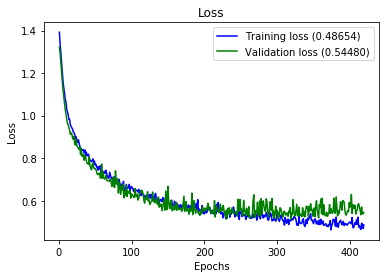

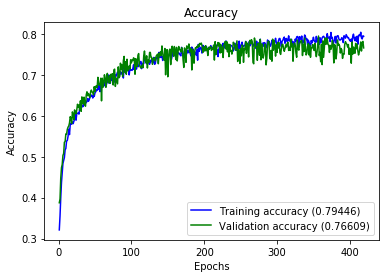

In [13]:
plot_history(history)